In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
from sklearn.linear_model import LassoCV, LinearRegression
from hmmlearn import hmm
import time

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# Input raw data (two first lines for Corbin and Young)

input_df = pd.read_csv('~/Desktop/Corbin SBU/AMS 520/Project/BofA Projects Data/EOD_20210908.csv',
# input_df = pd.read_csv('D:\\EOD\\EOD_20210908.csv',
                       header = None,
                       names = ['Ticker', # Label columns
                                'Date',
                                'Open',
                                'High',
                                'Low',
                                'Close',
                                'Volume',
                                'Dividend',
                                'Stock_split',
                                'Adj_open',
                                'Adj_high',
                                'Adj_low',
                                'Adj_close',
                                'Adj_volume'])

In [3]:
def asset_data(input_df,
               ticker='SPY',
               lookback=260):
    """
    Function purpose
    -------------------------------------
    Generate asset data
    
    Parameters
    ----------
    input_df : dataframe
        Historical data for asset, must include the following columns:
            - 'Ticker'
            - 'Date'
            - 'Adj_open'
            - 'Adj_high'
            - 'Adj_low'
            - 'Adj_close'
    ticker : str
        Selected asset
    lookback : int
        Lookback period (days)
    
    Return
    ------
    Data for selected asset
    """
    
    # Select which index to use for analysis
    data = input_df.loc[input_df['Ticker'] == ticker]
    data.reset_index(inplace=True, drop=True)
    data.set_index('Date', inplace=True)
    
    # Compute daily percentage returns
    returns = 100*(data['Adj_close'] - data['Adj_close'].shift(1)) / data['Adj_close'].shift(1)
    data['Returns'] = returns
    
    # Compute daily volatility
    volatility = get_ohlc_vol(data,
                              lookback=Neff)
    data['Volatility'] = volatility
    
    return data

In [4]:
# Proposed Idea: Create a HMM for the recent Neff days, and for all days after the Neff'th day
# predict which state we are currently in based on the Neff recent days.
# Be fully invested if in a positive market, fully divested in a negative market, but cash position grows from investment in Treasury.

def dynamicHMM(input_df,
               ticker='SPY',
               regression=True,
               lassoCV=True,
               cv=5,
               lookback=260,
               reg_lookback=21):
    """
    Function purpose
    -------------------------------------
    Generate portfolio returns for a regime-switching model
    
    
    Parameters
    ----------
    input_df : dataframe
        Historical data for asset, must include the following columns:
            - 'Ticker'
            - 'Date'
            - 'Adj_open'
            - 'Adj_high'
            - 'Adj_low'
            - 'Adj_close'
    ticker : str
        Selected asset
    regression : True/False
        Select True to include a regression in the model
    lassoCV : True/False
        Select True to perform a LassoCV regression
        Select False to perform a Linear regression
    lookback : int
        Lookback period (days)
    reg_lookback : int
        Lookback period (days) for regression
    
    Return
    ------
    Array of states over time (i.e. list of 0s and 1s for negative states and positive states, respectively)
    """

    # Generate stock data
    data = asset_data(input_df,
                      ticker=ticker,
                      lookback=lookback)
    # Adjust volatility input for nuances with GaussianHMM function
    if (not lassoCV) or (not regression):
        data['Volatility'] *= 100

    if regression:
        # Sources: stlouisfed.org, yahoo finance
        # Helpful guids: https://rdrr.io/github/AndreMikulec/econModel/src/R/StressIndex.R
        # Regression to use to predict index

        # Input regression data (two first lines for Corbin and Young)
        reg_df = pd.read_excel('~/Desktop/Corbin SBU/AMS 520/Project/Project Code/GitHub/Regime-Detection-HMM/Regression_Variables.xlsx')
        # reg_df = pd.read_excel('C:\\Users\\ryans\\Desktop\\AMS\\520\\Regression_Variables.xlsx')

        # Perform LassoCV regression to predict day-ahead asset returns
        reg_df.rename(columns={'observation_date': 'Date'}, inplace=True)
        reg_df.set_index('Date', inplace=True)

        # Merge regression data with asset data
        merged_data = data.join(reg_df, how='outer').loc[data.index[0]:data.index[-1],].dropna(subset=['Ticker'])
        merged_data.drop(columns=['Ticker',
                              'Open',
                              'High',
                              'Low',
                              'Close',
                              'Volume',
                              'Dividend',
                              'Stock_split',
                              'Adj_open',
                              'Adj_high',
                              'Adj_low',
                              'Adj_close',
                              'Adj_volume',
                              'Volatility'],
                    inplace=True)

        # Fill all missing data points with the most recently available value
        merged_data.fillna(method = 'ffill', inplace = True)

        # Perform a regression to predict day-ahead returns
        if lassoCV:
            regression_pred = LassoCVReg(merged_data,
                                         cv,
                                         lookback=reg_lookback)
        else:
            regression_pred = LinReg(merged_data,
                                     lookback=reg_lookback)
            
        # Store predicted returns in a dataframe
        reg_predicted_returns = pd.DataFrame(index=data.index[-len(regression_pred):],
                                             data=regression_pred,
                                             columns=['Regression_Prediction'])
        
        # Merge predicted returns with daily SPY data
        data = data.join(reg_predicted_returns, how='outer')
        print(data)
    else:
        reg_df = None
        
    # Fit the HMM for each time step
    current_state = fitHMM(data,
                           regression=regression,
                           lookback=lookback)

    return data, reg_df, current_state

In [5]:
def get_ohlc_vol(data,
                 lookback=260):
    """
    Function purpose
    -------------------------------------
    Create a series of OHLC volatilities based upon historical asset data
    
    Parameters
    ----------
    data : dataframe
        Historical data for asset, must include the following columns:
            - 'Adj_open'
            - 'Adj_high'
            - 'Adj_low'
            - 'Adj_close'
    lookback : int
        Lookback period (days)
    
    Return
    ------
    Volatility at each time step
    
    Source
    ------
    https://dynamiproject.files.wordpress.com/2016/01/measuring_historic_volatility.pdf
    Yang-Zhang Method
    """
    
    o = data.Adj_open
    h = data.Adj_high
    l = data.Adj_low
    c = data.Adj_close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    
    # close_vol = pd.rolling_sum(cc_sq, window=lookback) * (1.0 / (lookback - 1.0))
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))

    # open_vol = pd.rolling_sum(oc_sq, window=lookback) * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum()  * (1.0 / (lookback - 1.0))
    
    # window_rs = pd.rolling_sum(rs, window=lookback) * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    
    volatility = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    volatility[:lookback-1] = 0.0
    
    return volatility

In [6]:
def LassoCVReg(merged_data,
               cv=5,
               lookback=21):
    """
    Function purpose
    -------------------------------------
    Perform a Lasso CV regression to predict day-ahead asset returns
    
    Parameters
    ----------
    merged_data : dataframe
        Historical data for asset and regression inputs
    cv : int
        Number of cross-validation folds
    lookback : int
        Lookback period (days)
    
    Return
    ------
    Predicted day-ahead asset returns
    """

    regression_pred = np.array([]) # Store predicted asset return values

    for i in range(len(merged_data) - lookback):

        print(f'LassoCV Regression: {i}')

        # Check if and which independent variables have NA values
        na_check = pd.isna(merged_data.iloc[i:lookback + i, 1:])
        ind_var_available = np.array([])

        # Include independent variables only if they have sufficient data, i.e. lookback number of days at each time step
        for j, k in enumerate(na_check):
            if not any(na_check.loc[:,k]):
                ind_var_available = np.append(ind_var_available, j+1)

        ind_var_available = ind_var_available.astype(np.int)

        X = merged_data.iloc[i:lookback + i, ind_var_available].to_numpy()
        y = merged_data['Returns'][1 + i:lookback + 1 + i].to_numpy()

        lassoCV = LassoCV(cv=cv)
        lassoCV.fit(X, y)
        regression_pred = np.append(regression_pred, lassoCV.predict([X[-1]])[0])
        
    return regression_pred

In [7]:
def LinReg(merged_data,
           lookback=21):
    """
    Function purpose
    -------------------------------------
    Perform a Linear regression to predict day-ahead asset returns
    
    Parameters
    ----------
    merged_data : dataframe
        Historical data for asset and regression inputs
    lookback : int
        Lookback period (days)
    
    Return
    ------
    Predicted day-ahead asset returns
    """

    regression_pred = np.array([]) # Store predicted asset return values

    for i in range(len(merged_data) - lookback):

        print(f'Linear Regression: {i}')

        # Check if and which independent variables have NA values
        na_check = pd.isna(merged_data.iloc[i:lookback + i, 1:])
        ind_var_available = np.array([])

        # Include independent variables only if they have sufficient data, i.e. lookback number of days at each time step
        for j, k in enumerate(na_check):
            if not any(na_check.loc[:,k]):
                ind_var_available = np.append(ind_var_available, j+1)

        ind_var_available = ind_var_available.astype(np.int)

        X = merged_data.iloc[i:lookback + i, ind_var_available].to_numpy()
        y = merged_data['Returns'][1 + i:lookback + 1 + i].to_numpy()

        linReg = LinearRegression()
        linReg.fit(X, y)
        regression_pred = np.append(regression_pred, linReg.predict([X[-1]])[0])

    return regression_pred

In [8]:
def fitHMM(data,
           regression=True,
           lookback=260):
    """
    Function purpose
    -------------------------------------
    Perform an hmm.GaussianHMM (Hidden Markov Model) fit for each time step using a rolling lookback window
    
    Parameters
    ----------
    data : dataframe
        Historical data for asset and regression inputs, must include the following columns:
            - 'Returns'
            - 'Volatility'
            - 'Regression_Prediction' (if regression=True)
    regression : True/False
        Select True to include a regression in the HMM        
    lookback : int
        Lookback period (days)
    
    Return
    ------
    Array of states over time (i.e. list of 0s and 1s for negative states and positive states, respectively)
    """

    current_state = np.array([]) # Initialize an array to track the current regimes

    # Exclude first (to calculate trailing volatility) and
    # second (to have a full set of observations to fit a HMM) lookback number of days of observations
    for i in range(len(data) - 2*lookback):

        print(f'HMM fit: {i}')

        # Initialize a Gaussian HMM
        model = hmm.GaussianHMM(n_components = states, covariance_type=covariance_type, n_iter = max_iterations)

        # Pull lookback days of observations of returns, volatility, and day-ahead predicted returns (if included)
        if regression:
            observations = data.iloc[i + lookback:i + 2*lookback,:].loc[:,['Returns', 'Volatility', 'Regression_Prediction']].to_numpy()
        else:
            observations = data.iloc[i + lookback:i + 2*lookback,:].loc[:,['Returns', 'Volatility']].to_numpy()

        model.fit(observations) # Fit the model to the observations

        # Model randomly allocates a '0' or a '1' to a state, so check which state has the higher mean return
        if model.means_[0,0] > model.means_[1,0]:
            positive_state = 0
        else:
            positive_state = 1

        predictions = model.predict(observations) # Predict the state for each observation

        if positive_state == 1: # If the state with the higer mean return is state 1, do nothing, if not...
            pass
        else: # Switch the predicted regimes to ensure state 1 is always the regime with a greater mean return
            zeros = np.where(predictions == 0)
            ones = np.where(predictions == 1)
            predictions[zeros] = 1
            predictions[ones] = 0

        # Append the current state to the regime tracker
        current_state = np.append(current_state,predictions[-1])

    # Switch values from type float to type int for later calculations
    current_state = current_state.astype(np.int64)
    
    return current_state

In [9]:
def regime_switching_stats(current_state):
    """
    Function purpose
    -------------------------------------
    Compute regime switching metrics
    
    Parameters
    ----------
    current_state : array
        Current market state
    
    Return
    ------
    Output regime switching information
    """

    # Number of regime change in the data sets
    total_regime_switches = sum(np.abs(current_state[1:] - current_state[:-1]))

    years_of_data = len(current_state) / trading_days
    avg_regime_changes_per_year = total_regime_switches / years_of_data

    print(f'Total regime switches: {total_regime_switches}')
    print(f'Average number of regime switches per year: {avg_regime_changes_per_year:.01f}')

In [10]:
def regime_switching_plot(data,
                          current_state,
                          lookback=260):
    """
    Function purpose
    -------------------------------------
    Produce a plot of regime changes
    
    Parameters
    ----------
    data : dataframe
        Historical data for asset, must have 'Date' as the index
    current_state : array
        Current market state
    lookback : int
        Lookback period (days)
        
    Return
    ------
    Output plot of regime changes
    """

    dates = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in data.index[2*lookback:]]

    fig, ax = plt.subplots(figsize=(18,3))

    formatter = mdates.DateFormatter("%Y")

    ax.xaxis.set_major_formatter(formatter)

    fmt_half_year = mdates.MonthLocator(interval=24)
    ax.xaxis.set_major_locator(fmt_half_year)

    ax.plot(dates, current_state, '.', color = 'royalblue');

In [11]:
def regime_state_stats(data,
                       current_state,
                       lookback=260):
    """
    Function purpose
    -------------------------------------
    Compute basic stats for each state
    
    Parameters
    ----------
    data : dataframe
        Historical data for asset, must have 'Date' as the index
    current_state : array
        Current market state
    lookback : int
        Lookback period (days)
        
    Return
    ------
    Output regime statistics
    """

    state_0 = np.where(current_state == 0)[0] + 2*lookback
    state_1 = np.where(current_state == 1)[0] + 2*lookback

    print(f'Number of occurences of state 0: {len(state_0)}')
    print(f'Mean return of state 0: {data.iloc[state_0].Returns.mean():.03f}')
    print(f'Volatility of state 0: {data.iloc[state_0].Returns.std():.03f}')
    print('\n')
    print(f'Number of occurences of state 1: {len(state_1)}')
    print(f'Mean return of state 1: {data.iloc[state_1].Returns.mean():.03f}')
    print(f'Volatility of state 1: {data.iloc[state_1].Returns.std():.03f}')

In [12]:
def asset_switching_plot(data,
                         current_state,
                         lookback=260):
    """
    Function purpose
    -------------------------------------
    Produce a plot of the asset, colored by regime, over time
    
    Parameters
    ----------
    data : dataframe
        Historical data for asset, must have 'Date' as the index
    current_state : array
        Current market state
    lookback : int
        Lookback period (days)
        
    Return
    ------
    Output plot of asset dynamics
    """

    plot = sns.relplot(x = range(0,len(current_state)),
                       y = "Adj_close",
                       data = data[2*lookback:],
                       hue = current_state,
                       linewidth = 0,
                       palette = "Set2",
                       s = 10);

    plot.fig.set_size_inches(18,10)

In [13]:
def portfolio_performance(data,
                          current_state,
                          lookback=260):
    """
    Function purpose
    -------------------------------------
    Compute portfolio performance
    
    Parameters
    ----------
    data : dataframe
        Historical data for asset, must have 'Date' as the index
    current_state : array
        Current market state
    lookback : int
        Lookback period (days)
        
    Return
    ------
    Array of closing portfolio value
    """

    reg_df = pd.read_excel('~/Desktop/Corbin SBU/AMS 520/Project/Project Code/GitHub/Regime-Detection-HMM/Regression_Variables.xlsx')
    reg_df.set_index('observation_date', inplace=True)
    
    # Plan to invest in treasury if divested (state 0)
    daily_10_year_treas = pd.DataFrame(reg_df.loc[:,'Var3_10_Yr_Treas'], index=reg_df.index)**(1/252) - 1
    daily_10_year_treas.fillna(method = 'ffill', inplace = True)
    
    # Merge treasury with data
    data = data.join(daily_10_year_treas, how='outer').loc[data.index[0]:data.index[-1],:].dropna(subset=['Ticker'])
    
    # Compute portfolio returns
    portfolio_returns = current_state * data.Returns[2*lookback:] / 100 + (1 - current_state) * data.Var3_10_Yr_Treas[2*lookback:] / 100 + 1
    
    # Compute portfolio performance
    portfolio_perf = data.Adj_close[2*Neff-1] * np.cumprod(portfolio_returns)
    
    return portfolio_perf

In [14]:
def asset_switching_and_portfolio_plot(data,
                                       current_state,
                                       portfolio_performance,
                                       lookback=260):
    """
    Function purpose
    -------------------------------------
    Produce a plot of the asset, colored by regime, and the our portfolio over time
    
    Parameters
    ----------
    data : dataframe
        Historical data for asset, must have 'Date' as the index
    current_state : array
        Current market state
    portfolio_performance : array
        Closing value of portfolio
    lookback : int
        Lookback period (days)
        
    Return
    ------
    Output plot of asset and portfolio dynamics
    """

    plot = sns.relplot(x = range(0,len(current_state)),
                       y = "Adj_close",
                       data = data[2*Neff:],
                       hue = current_state,
                       linewidth = 0,
                       palette = "Set2",
                       s = 10);

    plt.plot(range(0,len(current_state)), portfolio_performance, color='royalblue')
    plt.legend(['HMM Portfolio','SPY (state 1)', 'SPY (state 0)'])

    plot.fig.set_size_inches(14,7)

In [15]:
def sharpe_ratio(portfolio_perf,
                 trading_days=252):
    """
    Function purpose
    -------------------------------------
    Computes the annualized sharpe ratio of the portfolio, assumes no risk-free rate
    
    Parameters
    ----------
    portfolio_perf : array
        Closing value of portfolio
    trading_days : int
        Number of trading days in period (daily, monthly, etc.)
        
    Return
    ------
    Annualized sharpe ratio
    """    

    # Compute portfolio daily returns
    portfolio_perf_returns = portfolio_perf.pct_change(1)
    
    portfolio_sharpe = portfolio_perf_returns.mean() / portfolio_perf_returns.std() * np.sqrt(trading_days)
    
    return portfolio_sharpe

In [16]:
def save_portfolio_performance(portfolio_perf,
                               Neff=260,
                               regression=True):
    """
    Function purpose
    -------------------------------------
    Save portfolio performance given different inputs
    
    Parameters
    ----------
    portfolio_perf : array
        Closing value of portfolio
    Neff : int
        Lookback period (days)
    regression : True/False
        Select True to include a regression in the model
        
    Return
    ------
    Saves .csv file to specified folder
    """
    
    Neff_str = str(Neff)
    if lassoCV and regression:
        reg_str = 'lassoCV'
    elif (not lassoCV) and regression:
        reg_str = 'LinReg'
    else:
        reg_str = 'NoReg'

    np.savetxt('Portfolio_Performances/portfolio' + '_' + Neff_str + '_' + reg_str + '.csv',
#    np.savetxt('Portfolio_Performances/portfolio' + '_' + Neff_str + '_' + reg_str + '2.csv',
               portfolio_perf,
               delimiter=',')

In [17]:
# Data inputs
ticker = 'SPY' # Selected asset

# Model inputs
trading_days = 252 # Approximately 252 trading days in a year
Neff = 200 # Lookback period

# Regression inputs
regression = True
reg_lookback = 21 # Representing trading days in a month
lassoCV = True
cv = 5 # Number of CV folds

# GaussianHMM inputs
states = 2 # Number of states
covariance_type = 'full' # Covariance method
max_iterations = 100 # For EM algorithm

In [18]:
def compute_portfolio_save_performance(input_df=input_df,
                                       ticker=ticker,
                                       regression=regression,
                                       lassoCV=lassoCV,
                                       cv=cv,
                                       lookback=Neff,
                                       reg_lookback=reg_lookback):

    start = time.time()

    data, reg_df, current_state = dynamicHMM(input_df,
                                             ticker=ticker,
                                             regression=regression,
                                             lassoCV=lassoCV,
                                             cv=cv,
                                             lookback=Neff,
                                             reg_lookback=reg_lookback)
    
    regime_switching_stats(current_state)

    regime_switching_plot(data,
                          current_state,
                          lookback=Neff)

    regime_state_stats(data,
                       current_state,
                       lookback=Neff)

    asset_switching_plot(data,
                         current_state,
                         lookback=Neff)

    portfolio_perf = portfolio_performance(data,
                                           current_state,
                                           lookback=Neff)

    asset_switching_and_portfolio_plot(data,
                                       current_state,
                                       portfolio_performance=portfolio_perf,
                                       lookback=Neff)

    portfolio_sharpe = sharpe_ratio(portfolio_perf=portfolio_perf,
                                    trading_days=trading_days)
    print(f'Sharpe Ratio: {portfolio_sharpe:.3f}')
    
    save_portfolio_performance(portfolio_perf=portfolio_perf,
                               Neff=Neff,
                               regression=regression)

    end = time.time()
    print(f'Computation time (seconds): {end - start:0f}')
    
    return data, reg_df, current_state, portfolio_perf, portfolio_sharpe

LassoCV Regression: 0
LassoCV Regression: 1
LassoCV Regression: 2
LassoCV Regression: 3
LassoCV Regression: 4
LassoCV Regression: 5
LassoCV Regression: 6
LassoCV Regression: 7
LassoCV Regression: 8
LassoCV Regression: 9
LassoCV Regression: 10
LassoCV Regression: 11
LassoCV Regression: 12
LassoCV Regression: 13
LassoCV Regression: 14
LassoCV Regression: 15
LassoCV Regression: 16
LassoCV Regression: 17
LassoCV Regression: 18
LassoCV Regression: 19
LassoCV Regression: 20
LassoCV Regression: 21
LassoCV Regression: 22
LassoCV Regression: 23
LassoCV Regression: 24
LassoCV Regression: 25
LassoCV Regression: 26
LassoCV Regression: 27
LassoCV Regression: 28
LassoCV Regression: 29
LassoCV Regression: 30
LassoCV Regression: 31
LassoCV Regression: 32
LassoCV Regression: 33
LassoCV Regression: 34
LassoCV Regression: 35
LassoCV Regression: 36
LassoCV Regression: 37
LassoCV Regression: 38
LassoCV Regression: 39
LassoCV Regression: 40
LassoCV Regression: 41
LassoCV Regression: 42
LassoCV Regression: 4

LassoCV Regression: 346
LassoCV Regression: 347
LassoCV Regression: 348
LassoCV Regression: 349
LassoCV Regression: 350
LassoCV Regression: 351
LassoCV Regression: 352
LassoCV Regression: 353
LassoCV Regression: 354
LassoCV Regression: 355
LassoCV Regression: 356
LassoCV Regression: 357
LassoCV Regression: 358
LassoCV Regression: 359
LassoCV Regression: 360
LassoCV Regression: 361
LassoCV Regression: 362
LassoCV Regression: 363
LassoCV Regression: 364
LassoCV Regression: 365
LassoCV Regression: 366
LassoCV Regression: 367
LassoCV Regression: 368
LassoCV Regression: 369
LassoCV Regression: 370
LassoCV Regression: 371
LassoCV Regression: 372
LassoCV Regression: 373
LassoCV Regression: 374
LassoCV Regression: 375
LassoCV Regression: 376
LassoCV Regression: 377
LassoCV Regression: 378
LassoCV Regression: 379
LassoCV Regression: 380
LassoCV Regression: 381
LassoCV Regression: 382
LassoCV Regression: 383
LassoCV Regression: 384
LassoCV Regression: 385
LassoCV Regression: 386
LassoCV Regressi

LassoCV Regression: 688
LassoCV Regression: 689
LassoCV Regression: 690
LassoCV Regression: 691
LassoCV Regression: 692
LassoCV Regression: 693
LassoCV Regression: 694
LassoCV Regression: 695
LassoCV Regression: 696
LassoCV Regression: 697
LassoCV Regression: 698
LassoCV Regression: 699
LassoCV Regression: 700
LassoCV Regression: 701
LassoCV Regression: 702
LassoCV Regression: 703
LassoCV Regression: 704
LassoCV Regression: 705
LassoCV Regression: 706
LassoCV Regression: 707
LassoCV Regression: 708
LassoCV Regression: 709
LassoCV Regression: 710
LassoCV Regression: 711
LassoCV Regression: 712
LassoCV Regression: 713
LassoCV Regression: 714
LassoCV Regression: 715
LassoCV Regression: 716
LassoCV Regression: 717
LassoCV Regression: 718
LassoCV Regression: 719
LassoCV Regression: 720
LassoCV Regression: 721
LassoCV Regression: 722
LassoCV Regression: 723
LassoCV Regression: 724
LassoCV Regression: 725
LassoCV Regression: 726
LassoCV Regression: 727
LassoCV Regression: 728
LassoCV Regressi

LassoCV Regression: 1029
LassoCV Regression: 1030
LassoCV Regression: 1031
LassoCV Regression: 1032
LassoCV Regression: 1033
LassoCV Regression: 1034
LassoCV Regression: 1035
LassoCV Regression: 1036
LassoCV Regression: 1037
LassoCV Regression: 1038
LassoCV Regression: 1039
LassoCV Regression: 1040
LassoCV Regression: 1041
LassoCV Regression: 1042
LassoCV Regression: 1043
LassoCV Regression: 1044
LassoCV Regression: 1045
LassoCV Regression: 1046
LassoCV Regression: 1047
LassoCV Regression: 1048
LassoCV Regression: 1049
LassoCV Regression: 1050
LassoCV Regression: 1051
LassoCV Regression: 1052
LassoCV Regression: 1053
LassoCV Regression: 1054
LassoCV Regression: 1055
LassoCV Regression: 1056
LassoCV Regression: 1057
LassoCV Regression: 1058
LassoCV Regression: 1059
LassoCV Regression: 1060
LassoCV Regression: 1061
LassoCV Regression: 1062
LassoCV Regression: 1063
LassoCV Regression: 1064
LassoCV Regression: 1065
LassoCV Regression: 1066
LassoCV Regression: 1067
LassoCV Regression: 1068


LassoCV Regression: 1357
LassoCV Regression: 1358
LassoCV Regression: 1359
LassoCV Regression: 1360
LassoCV Regression: 1361
LassoCV Regression: 1362
LassoCV Regression: 1363
LassoCV Regression: 1364
LassoCV Regression: 1365
LassoCV Regression: 1366
LassoCV Regression: 1367
LassoCV Regression: 1368
LassoCV Regression: 1369
LassoCV Regression: 1370
LassoCV Regression: 1371
LassoCV Regression: 1372
LassoCV Regression: 1373
LassoCV Regression: 1374
LassoCV Regression: 1375
LassoCV Regression: 1376
LassoCV Regression: 1377
LassoCV Regression: 1378
LassoCV Regression: 1379
LassoCV Regression: 1380
LassoCV Regression: 1381
LassoCV Regression: 1382
LassoCV Regression: 1383
LassoCV Regression: 1384
LassoCV Regression: 1385
LassoCV Regression: 1386
LassoCV Regression: 1387
LassoCV Regression: 1388
LassoCV Regression: 1389
LassoCV Regression: 1390
LassoCV Regression: 1391
LassoCV Regression: 1392
LassoCV Regression: 1393
LassoCV Regression: 1394
LassoCV Regression: 1395
LassoCV Regression: 1396


LassoCV Regression: 1686
LassoCV Regression: 1687
LassoCV Regression: 1688
LassoCV Regression: 1689
LassoCV Regression: 1690
LassoCV Regression: 1691
LassoCV Regression: 1692
LassoCV Regression: 1693
LassoCV Regression: 1694
LassoCV Regression: 1695
LassoCV Regression: 1696
LassoCV Regression: 1697
LassoCV Regression: 1698
LassoCV Regression: 1699
LassoCV Regression: 1700
LassoCV Regression: 1701
LassoCV Regression: 1702
LassoCV Regression: 1703
LassoCV Regression: 1704
LassoCV Regression: 1705
LassoCV Regression: 1706
LassoCV Regression: 1707
LassoCV Regression: 1708
LassoCV Regression: 1709
LassoCV Regression: 1710
LassoCV Regression: 1711
LassoCV Regression: 1712
LassoCV Regression: 1713
LassoCV Regression: 1714
LassoCV Regression: 1715
LassoCV Regression: 1716
LassoCV Regression: 1717
LassoCV Regression: 1718
LassoCV Regression: 1719
LassoCV Regression: 1720
LassoCV Regression: 1721
LassoCV Regression: 1722
LassoCV Regression: 1723
LassoCV Regression: 1724
LassoCV Regression: 1725


LassoCV Regression: 2014
LassoCV Regression: 2015
LassoCV Regression: 2016
LassoCV Regression: 2017
LassoCV Regression: 2018
LassoCV Regression: 2019
LassoCV Regression: 2020
LassoCV Regression: 2021
LassoCV Regression: 2022
LassoCV Regression: 2023
LassoCV Regression: 2024
LassoCV Regression: 2025
LassoCV Regression: 2026
LassoCV Regression: 2027
LassoCV Regression: 2028
LassoCV Regression: 2029
LassoCV Regression: 2030
LassoCV Regression: 2031
LassoCV Regression: 2032
LassoCV Regression: 2033
LassoCV Regression: 2034
LassoCV Regression: 2035
LassoCV Regression: 2036
LassoCV Regression: 2037
LassoCV Regression: 2038
LassoCV Regression: 2039
LassoCV Regression: 2040
LassoCV Regression: 2041
LassoCV Regression: 2042
LassoCV Regression: 2043
LassoCV Regression: 2044
LassoCV Regression: 2045
LassoCV Regression: 2046
LassoCV Regression: 2047
LassoCV Regression: 2048
LassoCV Regression: 2049
LassoCV Regression: 2050
LassoCV Regression: 2051
LassoCV Regression: 2052
LassoCV Regression: 2053


LassoCV Regression: 2342
LassoCV Regression: 2343
LassoCV Regression: 2344
LassoCV Regression: 2345
LassoCV Regression: 2346
LassoCV Regression: 2347
LassoCV Regression: 2348
LassoCV Regression: 2349
LassoCV Regression: 2350
LassoCV Regression: 2351
LassoCV Regression: 2352
LassoCV Regression: 2353
LassoCV Regression: 2354
LassoCV Regression: 2355
LassoCV Regression: 2356
LassoCV Regression: 2357
LassoCV Regression: 2358
LassoCV Regression: 2359
LassoCV Regression: 2360
LassoCV Regression: 2361
LassoCV Regression: 2362
LassoCV Regression: 2363
LassoCV Regression: 2364
LassoCV Regression: 2365
LassoCV Regression: 2366
LassoCV Regression: 2367
LassoCV Regression: 2368
LassoCV Regression: 2369
LassoCV Regression: 2370
LassoCV Regression: 2371
LassoCV Regression: 2372
LassoCV Regression: 2373
LassoCV Regression: 2374
LassoCV Regression: 2375
LassoCV Regression: 2376
LassoCV Regression: 2377
LassoCV Regression: 2378
LassoCV Regression: 2379
LassoCV Regression: 2380
LassoCV Regression: 2381


LassoCV Regression: 2670
LassoCV Regression: 2671
LassoCV Regression: 2672
LassoCV Regression: 2673
LassoCV Regression: 2674
LassoCV Regression: 2675
LassoCV Regression: 2676
LassoCV Regression: 2677
LassoCV Regression: 2678
LassoCV Regression: 2679
LassoCV Regression: 2680
LassoCV Regression: 2681
LassoCV Regression: 2682
LassoCV Regression: 2683
LassoCV Regression: 2684
LassoCV Regression: 2685
LassoCV Regression: 2686
LassoCV Regression: 2687
LassoCV Regression: 2688
LassoCV Regression: 2689
LassoCV Regression: 2690
LassoCV Regression: 2691
LassoCV Regression: 2692
LassoCV Regression: 2693
LassoCV Regression: 2694
LassoCV Regression: 2695
LassoCV Regression: 2696
LassoCV Regression: 2697
LassoCV Regression: 2698
LassoCV Regression: 2699
LassoCV Regression: 2700
LassoCV Regression: 2701
LassoCV Regression: 2702
LassoCV Regression: 2703
LassoCV Regression: 2704
LassoCV Regression: 2705
LassoCV Regression: 2706
LassoCV Regression: 2707
LassoCV Regression: 2708
LassoCV Regression: 2709


LassoCV Regression: 2998
LassoCV Regression: 2999
LassoCV Regression: 3000
LassoCV Regression: 3001
LassoCV Regression: 3002
LassoCV Regression: 3003
LassoCV Regression: 3004
LassoCV Regression: 3005
LassoCV Regression: 3006
LassoCV Regression: 3007
LassoCV Regression: 3008
LassoCV Regression: 3009
LassoCV Regression: 3010
LassoCV Regression: 3011
LassoCV Regression: 3012
LassoCV Regression: 3013
LassoCV Regression: 3014
LassoCV Regression: 3015
LassoCV Regression: 3016
LassoCV Regression: 3017
LassoCV Regression: 3018
LassoCV Regression: 3019
LassoCV Regression: 3020
LassoCV Regression: 3021
LassoCV Regression: 3022
LassoCV Regression: 3023
LassoCV Regression: 3024
LassoCV Regression: 3025
LassoCV Regression: 3026
LassoCV Regression: 3027
LassoCV Regression: 3028
LassoCV Regression: 3029
LassoCV Regression: 3030
LassoCV Regression: 3031
LassoCV Regression: 3032
LassoCV Regression: 3033
LassoCV Regression: 3034
LassoCV Regression: 3035
LassoCV Regression: 3036
LassoCV Regression: 3037


LassoCV Regression: 3327
LassoCV Regression: 3328
LassoCV Regression: 3329
LassoCV Regression: 3330
LassoCV Regression: 3331
LassoCV Regression: 3332
LassoCV Regression: 3333
LassoCV Regression: 3334
LassoCV Regression: 3335
LassoCV Regression: 3336
LassoCV Regression: 3337
LassoCV Regression: 3338
LassoCV Regression: 3339
LassoCV Regression: 3340
LassoCV Regression: 3341
LassoCV Regression: 3342
LassoCV Regression: 3343
LassoCV Regression: 3344
LassoCV Regression: 3345
LassoCV Regression: 3346
LassoCV Regression: 3347
LassoCV Regression: 3348
LassoCV Regression: 3349
LassoCV Regression: 3350
LassoCV Regression: 3351
LassoCV Regression: 3352
LassoCV Regression: 3353
LassoCV Regression: 3354
LassoCV Regression: 3355
LassoCV Regression: 3356
LassoCV Regression: 3357
LassoCV Regression: 3358
LassoCV Regression: 3359
LassoCV Regression: 3360
LassoCV Regression: 3361
LassoCV Regression: 3362
LassoCV Regression: 3363
LassoCV Regression: 3364
LassoCV Regression: 3365
LassoCV Regression: 3366


LassoCV Regression: 3655
LassoCV Regression: 3656
LassoCV Regression: 3657
LassoCV Regression: 3658
LassoCV Regression: 3659
LassoCV Regression: 3660
LassoCV Regression: 3661
LassoCV Regression: 3662
LassoCV Regression: 3663
LassoCV Regression: 3664
LassoCV Regression: 3665
LassoCV Regression: 3666
LassoCV Regression: 3667
LassoCV Regression: 3668
LassoCV Regression: 3669
LassoCV Regression: 3670
LassoCV Regression: 3671
LassoCV Regression: 3672
LassoCV Regression: 3673
LassoCV Regression: 3674
LassoCV Regression: 3675
LassoCV Regression: 3676
LassoCV Regression: 3677
LassoCV Regression: 3678
LassoCV Regression: 3679
LassoCV Regression: 3680
LassoCV Regression: 3681
LassoCV Regression: 3682
LassoCV Regression: 3683
LassoCV Regression: 3684
LassoCV Regression: 3685
LassoCV Regression: 3686
LassoCV Regression: 3687
LassoCV Regression: 3688
LassoCV Regression: 3689
LassoCV Regression: 3690
LassoCV Regression: 3691
LassoCV Regression: 3692
LassoCV Regression: 3693
LassoCV Regression: 3694


LassoCV Regression: 3984
LassoCV Regression: 3985
LassoCV Regression: 3986
LassoCV Regression: 3987
LassoCV Regression: 3988
LassoCV Regression: 3989
LassoCV Regression: 3990
LassoCV Regression: 3991
LassoCV Regression: 3992
LassoCV Regression: 3993
LassoCV Regression: 3994
LassoCV Regression: 3995
LassoCV Regression: 3996
LassoCV Regression: 3997
LassoCV Regression: 3998
LassoCV Regression: 3999
LassoCV Regression: 4000
LassoCV Regression: 4001
LassoCV Regression: 4002
LassoCV Regression: 4003
LassoCV Regression: 4004
LassoCV Regression: 4005
LassoCV Regression: 4006
LassoCV Regression: 4007
LassoCV Regression: 4008
LassoCV Regression: 4009
LassoCV Regression: 4010
LassoCV Regression: 4011
LassoCV Regression: 4012
LassoCV Regression: 4013
LassoCV Regression: 4014
LassoCV Regression: 4015
LassoCV Regression: 4016
LassoCV Regression: 4017
LassoCV Regression: 4018
LassoCV Regression: 4019
LassoCV Regression: 4020
LassoCV Regression: 4021
LassoCV Regression: 4022
LassoCV Regression: 4023


LassoCV Regression: 4312
LassoCV Regression: 4313
LassoCV Regression: 4314
LassoCV Regression: 4315
LassoCV Regression: 4316
LassoCV Regression: 4317
LassoCV Regression: 4318
LassoCV Regression: 4319
LassoCV Regression: 4320
LassoCV Regression: 4321
LassoCV Regression: 4322
LassoCV Regression: 4323
LassoCV Regression: 4324
LassoCV Regression: 4325
LassoCV Regression: 4326
LassoCV Regression: 4327
LassoCV Regression: 4328
LassoCV Regression: 4329
LassoCV Regression: 4330
LassoCV Regression: 4331
LassoCV Regression: 4332
LassoCV Regression: 4333
LassoCV Regression: 4334
LassoCV Regression: 4335
LassoCV Regression: 4336
LassoCV Regression: 4337
LassoCV Regression: 4338
LassoCV Regression: 4339
LassoCV Regression: 4340
LassoCV Regression: 4341
LassoCV Regression: 4342
LassoCV Regression: 4343
LassoCV Regression: 4344
LassoCV Regression: 4345
LassoCV Regression: 4346
LassoCV Regression: 4347
LassoCV Regression: 4348
LassoCV Regression: 4349
LassoCV Regression: 4350
LassoCV Regression: 4351


LassoCV Regression: 4641
LassoCV Regression: 4642
LassoCV Regression: 4643
LassoCV Regression: 4644
LassoCV Regression: 4645
LassoCV Regression: 4646
LassoCV Regression: 4647
LassoCV Regression: 4648
LassoCV Regression: 4649
LassoCV Regression: 4650
LassoCV Regression: 4651
LassoCV Regression: 4652
LassoCV Regression: 4653
LassoCV Regression: 4654
LassoCV Regression: 4655
LassoCV Regression: 4656
LassoCV Regression: 4657
LassoCV Regression: 4658
LassoCV Regression: 4659
LassoCV Regression: 4660
LassoCV Regression: 4661
LassoCV Regression: 4662
LassoCV Regression: 4663
LassoCV Regression: 4664
LassoCV Regression: 4665
LassoCV Regression: 4666
LassoCV Regression: 4667
LassoCV Regression: 4668
LassoCV Regression: 4669
LassoCV Regression: 4670
LassoCV Regression: 4671
LassoCV Regression: 4672
LassoCV Regression: 4673
LassoCV Regression: 4674
LassoCV Regression: 4675
LassoCV Regression: 4676
LassoCV Regression: 4677
LassoCV Regression: 4678
LassoCV Regression: 4679
LassoCV Regression: 4680


LassoCV Regression: 4970
LassoCV Regression: 4971
LassoCV Regression: 4972
LassoCV Regression: 4973
LassoCV Regression: 4974
LassoCV Regression: 4975
LassoCV Regression: 4976
LassoCV Regression: 4977
LassoCV Regression: 4978
LassoCV Regression: 4979
LassoCV Regression: 4980
LassoCV Regression: 4981
LassoCV Regression: 4982
LassoCV Regression: 4983
LassoCV Regression: 4984
LassoCV Regression: 4985
LassoCV Regression: 4986
LassoCV Regression: 4987
LassoCV Regression: 4988
LassoCV Regression: 4989
LassoCV Regression: 4990
LassoCV Regression: 4991
LassoCV Regression: 4992
LassoCV Regression: 4993
LassoCV Regression: 4994
LassoCV Regression: 4995
LassoCV Regression: 4996
LassoCV Regression: 4997
LassoCV Regression: 4998
LassoCV Regression: 4999
LassoCV Regression: 5000
LassoCV Regression: 5001
LassoCV Regression: 5002
LassoCV Regression: 5003
LassoCV Regression: 5004
LassoCV Regression: 5005
LassoCV Regression: 5006
LassoCV Regression: 5007
LassoCV Regression: 5008
LassoCV Regression: 5009


LassoCV Regression: 5298
LassoCV Regression: 5299
LassoCV Regression: 5300
LassoCV Regression: 5301
LassoCV Regression: 5302
LassoCV Regression: 5303
LassoCV Regression: 5304
LassoCV Regression: 5305
LassoCV Regression: 5306
LassoCV Regression: 5307
LassoCV Regression: 5308
LassoCV Regression: 5309
LassoCV Regression: 5310
LassoCV Regression: 5311
LassoCV Regression: 5312
LassoCV Regression: 5313
LassoCV Regression: 5314
LassoCV Regression: 5315
LassoCV Regression: 5316
LassoCV Regression: 5317
LassoCV Regression: 5318
LassoCV Regression: 5319
LassoCV Regression: 5320
LassoCV Regression: 5321
LassoCV Regression: 5322
LassoCV Regression: 5323
LassoCV Regression: 5324
LassoCV Regression: 5325
LassoCV Regression: 5326
LassoCV Regression: 5327
LassoCV Regression: 5328
LassoCV Regression: 5329
LassoCV Regression: 5330
LassoCV Regression: 5331
LassoCV Regression: 5332
LassoCV Regression: 5333
LassoCV Regression: 5334
LassoCV Regression: 5335
LassoCV Regression: 5336
LassoCV Regression: 5337


LassoCV Regression: 5626
LassoCV Regression: 5627
LassoCV Regression: 5628
LassoCV Regression: 5629
LassoCV Regression: 5630
LassoCV Regression: 5631
LassoCV Regression: 5632
LassoCV Regression: 5633
LassoCV Regression: 5634
LassoCV Regression: 5635
LassoCV Regression: 5636
LassoCV Regression: 5637
LassoCV Regression: 5638
LassoCV Regression: 5639
LassoCV Regression: 5640
LassoCV Regression: 5641
LassoCV Regression: 5642
LassoCV Regression: 5643
LassoCV Regression: 5644
LassoCV Regression: 5645
LassoCV Regression: 5646
LassoCV Regression: 5647
LassoCV Regression: 5648
LassoCV Regression: 5649
LassoCV Regression: 5650
LassoCV Regression: 5651
LassoCV Regression: 5652
LassoCV Regression: 5653
LassoCV Regression: 5654
LassoCV Regression: 5655
LassoCV Regression: 5656
LassoCV Regression: 5657
LassoCV Regression: 5658
LassoCV Regression: 5659
LassoCV Regression: 5660
LassoCV Regression: 5661
LassoCV Regression: 5662
LassoCV Regression: 5663
LassoCV Regression: 5664
LassoCV Regression: 5665


LassoCV Regression: 5956
LassoCV Regression: 5957
LassoCV Regression: 5958
LassoCV Regression: 5959
LassoCV Regression: 5960
LassoCV Regression: 5961
LassoCV Regression: 5962
LassoCV Regression: 5963
LassoCV Regression: 5964
LassoCV Regression: 5965
LassoCV Regression: 5966
LassoCV Regression: 5967
LassoCV Regression: 5968
LassoCV Regression: 5969
LassoCV Regression: 5970
LassoCV Regression: 5971
LassoCV Regression: 5972
LassoCV Regression: 5973
LassoCV Regression: 5974
LassoCV Regression: 5975
LassoCV Regression: 5976
LassoCV Regression: 5977
LassoCV Regression: 5978
LassoCV Regression: 5979
LassoCV Regression: 5980
LassoCV Regression: 5981
LassoCV Regression: 5982
LassoCV Regression: 5983
LassoCV Regression: 5984
LassoCV Regression: 5985
LassoCV Regression: 5986
LassoCV Regression: 5987
LassoCV Regression: 5988
LassoCV Regression: 5989
LassoCV Regression: 5990
LassoCV Regression: 5991
LassoCV Regression: 5992
LassoCV Regression: 5993
LassoCV Regression: 5994
LassoCV Regression: 5995


LassoCV Regression: 6284
LassoCV Regression: 6285
LassoCV Regression: 6286
LassoCV Regression: 6287
LassoCV Regression: 6288
LassoCV Regression: 6289
LassoCV Regression: 6290
LassoCV Regression: 6291
LassoCV Regression: 6292
LassoCV Regression: 6293
LassoCV Regression: 6294
LassoCV Regression: 6295
LassoCV Regression: 6296
LassoCV Regression: 6297
LassoCV Regression: 6298
LassoCV Regression: 6299
LassoCV Regression: 6300
LassoCV Regression: 6301
LassoCV Regression: 6302
LassoCV Regression: 6303
LassoCV Regression: 6304
LassoCV Regression: 6305
LassoCV Regression: 6306
LassoCV Regression: 6307
LassoCV Regression: 6308
LassoCV Regression: 6309
LassoCV Regression: 6310
LassoCV Regression: 6311
LassoCV Regression: 6312
LassoCV Regression: 6313
LassoCV Regression: 6314
LassoCV Regression: 6315
LassoCV Regression: 6316
LassoCV Regression: 6317
LassoCV Regression: 6318
LassoCV Regression: 6319
LassoCV Regression: 6320
LassoCV Regression: 6321
LassoCV Regression: 6322
LassoCV Regression: 6323


LassoCV Regression: 6613
LassoCV Regression: 6614
LassoCV Regression: 6615
LassoCV Regression: 6616
LassoCV Regression: 6617
LassoCV Regression: 6618
LassoCV Regression: 6619
LassoCV Regression: 6620
LassoCV Regression: 6621
LassoCV Regression: 6622
LassoCV Regression: 6623
LassoCV Regression: 6624
LassoCV Regression: 6625
LassoCV Regression: 6626
LassoCV Regression: 6627
LassoCV Regression: 6628
LassoCV Regression: 6629
LassoCV Regression: 6630
LassoCV Regression: 6631
LassoCV Regression: 6632
LassoCV Regression: 6633
LassoCV Regression: 6634
LassoCV Regression: 6635
LassoCV Regression: 6636
LassoCV Regression: 6637
LassoCV Regression: 6638
LassoCV Regression: 6639
LassoCV Regression: 6640
LassoCV Regression: 6641
LassoCV Regression: 6642
LassoCV Regression: 6643
LassoCV Regression: 6644
LassoCV Regression: 6645
LassoCV Regression: 6646
LassoCV Regression: 6647
LassoCV Regression: 6648
LassoCV Regression: 6649
LassoCV Regression: 6650
LassoCV Regression: 6651
LassoCV Regression: 6652


LassoCV Regression: 6943
LassoCV Regression: 6944
LassoCV Regression: 6945
LassoCV Regression: 6946
LassoCV Regression: 6947
LassoCV Regression: 6948
LassoCV Regression: 6949
LassoCV Regression: 6950
LassoCV Regression: 6951
LassoCV Regression: 6952
LassoCV Regression: 6953
LassoCV Regression: 6954
LassoCV Regression: 6955
LassoCV Regression: 6956
LassoCV Regression: 6957
LassoCV Regression: 6958
LassoCV Regression: 6959
LassoCV Regression: 6960
LassoCV Regression: 6961
LassoCV Regression: 6962
LassoCV Regression: 6963
LassoCV Regression: 6964
LassoCV Regression: 6965
LassoCV Regression: 6966
LassoCV Regression: 6967
LassoCV Regression: 6968
LassoCV Regression: 6969
LassoCV Regression: 6970
LassoCV Regression: 6971
LassoCV Regression: 6972
LassoCV Regression: 6973
LassoCV Regression: 6974
LassoCV Regression: 6975
LassoCV Regression: 6976
LassoCV Regression: 6977
LassoCV Regression: 6978
LassoCV Regression: 6979
LassoCV Regression: 6980
LassoCV Regression: 6981
LassoCV Regression: 6982


HMM fit: 1
HMM fit: 2
HMM fit: 3
HMM fit: 4
HMM fit: 5
HMM fit: 6
HMM fit: 7
HMM fit: 8
HMM fit: 9
HMM fit: 10
HMM fit: 11
HMM fit: 12
HMM fit: 13
HMM fit: 14
HMM fit: 15
HMM fit: 16
HMM fit: 17
HMM fit: 18
HMM fit: 19
HMM fit: 20
HMM fit: 21
HMM fit: 22
HMM fit: 23
HMM fit: 24
HMM fit: 25
HMM fit: 26
HMM fit: 27
HMM fit: 28
HMM fit: 29
HMM fit: 30
HMM fit: 31
HMM fit: 32
HMM fit: 33
HMM fit: 34
HMM fit: 35
HMM fit: 36
HMM fit: 37
HMM fit: 38
HMM fit: 39
HMM fit: 40
HMM fit: 41
HMM fit: 42
HMM fit: 43
HMM fit: 44
HMM fit: 45
HMM fit: 46
HMM fit: 47
HMM fit: 48
HMM fit: 49
HMM fit: 50
HMM fit: 51
HMM fit: 52
HMM fit: 53
HMM fit: 54
HMM fit: 55
HMM fit: 56
HMM fit: 57
HMM fit: 58
HMM fit: 59
HMM fit: 60
HMM fit: 61
HMM fit: 62
HMM fit: 63
HMM fit: 64
HMM fit: 65
HMM fit: 66
HMM fit: 67
HMM fit: 68
HMM fit: 69
HMM fit: 70
HMM fit: 71
HMM fit: 72
HMM fit: 73
HMM fit: 74
HMM fit: 75
HMM fit: 76
HMM fit: 77
HMM fit: 78
HMM fit: 79
HMM fit: 80
HMM fit: 81
HMM fit: 82
HMM fit: 83
HMM fit: 84
H

HMM fit: 641
HMM fit: 642
HMM fit: 643
HMM fit: 644
HMM fit: 645
HMM fit: 646
HMM fit: 647
HMM fit: 648
HMM fit: 649
HMM fit: 650
HMM fit: 651
HMM fit: 652
HMM fit: 653
HMM fit: 654
HMM fit: 655
HMM fit: 656
HMM fit: 657
HMM fit: 658
HMM fit: 659
HMM fit: 660
HMM fit: 661
HMM fit: 662
HMM fit: 663
HMM fit: 664
HMM fit: 665
HMM fit: 666
HMM fit: 667
HMM fit: 668
HMM fit: 669
HMM fit: 670
HMM fit: 671
HMM fit: 672
HMM fit: 673
HMM fit: 674
HMM fit: 675
HMM fit: 676
HMM fit: 677
HMM fit: 678
HMM fit: 679
HMM fit: 680
HMM fit: 681
HMM fit: 682
HMM fit: 683
HMM fit: 684
HMM fit: 685
HMM fit: 686
HMM fit: 687
HMM fit: 688
HMM fit: 689
HMM fit: 690
HMM fit: 691
HMM fit: 692
HMM fit: 693
HMM fit: 694
HMM fit: 695
HMM fit: 696
HMM fit: 697
HMM fit: 698
HMM fit: 699
HMM fit: 700
HMM fit: 701
HMM fit: 702
HMM fit: 703
HMM fit: 704
HMM fit: 705
HMM fit: 706
HMM fit: 707
HMM fit: 708
HMM fit: 709
HMM fit: 710
HMM fit: 711
HMM fit: 712
HMM fit: 713
HMM fit: 714
HMM fit: 715
HMM fit: 716
HMM fit: 717

HMM fit: 1253
HMM fit: 1254
HMM fit: 1255
HMM fit: 1256
HMM fit: 1257
HMM fit: 1258
HMM fit: 1259
HMM fit: 1260
HMM fit: 1261
HMM fit: 1262
HMM fit: 1263
HMM fit: 1264
HMM fit: 1265
HMM fit: 1266
HMM fit: 1267
HMM fit: 1268
HMM fit: 1269
HMM fit: 1270
HMM fit: 1271
HMM fit: 1272
HMM fit: 1273
HMM fit: 1274
HMM fit: 1275
HMM fit: 1276
HMM fit: 1277
HMM fit: 1278
HMM fit: 1279
HMM fit: 1280
HMM fit: 1281
HMM fit: 1282
HMM fit: 1283
HMM fit: 1284
HMM fit: 1285
HMM fit: 1286
HMM fit: 1287
HMM fit: 1288
HMM fit: 1289
HMM fit: 1290
HMM fit: 1291
HMM fit: 1292
HMM fit: 1293
HMM fit: 1294
HMM fit: 1295
HMM fit: 1296
HMM fit: 1297
HMM fit: 1298
HMM fit: 1299
HMM fit: 1300
HMM fit: 1301
HMM fit: 1302
HMM fit: 1303
HMM fit: 1304
HMM fit: 1305
HMM fit: 1306
HMM fit: 1307
HMM fit: 1308
HMM fit: 1309
HMM fit: 1310
HMM fit: 1311
HMM fit: 1312
HMM fit: 1313
HMM fit: 1314
HMM fit: 1315
HMM fit: 1316
HMM fit: 1317
HMM fit: 1318
HMM fit: 1319
HMM fit: 1320
HMM fit: 1321
HMM fit: 1322
HMM fit: 1323
HMM fi

HMM fit: 1839
HMM fit: 1840
HMM fit: 1841
HMM fit: 1842
HMM fit: 1843
HMM fit: 1844
HMM fit: 1845
HMM fit: 1846
HMM fit: 1847
HMM fit: 1848
HMM fit: 1849
HMM fit: 1850
HMM fit: 1851
HMM fit: 1852
HMM fit: 1853
HMM fit: 1854
HMM fit: 1855
HMM fit: 1856
HMM fit: 1857
HMM fit: 1858
HMM fit: 1859
HMM fit: 1860
HMM fit: 1861
HMM fit: 1862
HMM fit: 1863
HMM fit: 1864
HMM fit: 1865
HMM fit: 1866
HMM fit: 1867
HMM fit: 1868
HMM fit: 1869
HMM fit: 1870
HMM fit: 1871
HMM fit: 1872
HMM fit: 1873
HMM fit: 1874
HMM fit: 1875
HMM fit: 1876
HMM fit: 1877
HMM fit: 1878
HMM fit: 1879
HMM fit: 1880
HMM fit: 1881
HMM fit: 1882
HMM fit: 1883
HMM fit: 1884
HMM fit: 1885
HMM fit: 1886
HMM fit: 1887
HMM fit: 1888
HMM fit: 1889
HMM fit: 1890
HMM fit: 1891
HMM fit: 1892
HMM fit: 1893
HMM fit: 1894
HMM fit: 1895
HMM fit: 1896
HMM fit: 1897
HMM fit: 1898
HMM fit: 1899
HMM fit: 1900
HMM fit: 1901
HMM fit: 1902
HMM fit: 1903
HMM fit: 1904
HMM fit: 1905
HMM fit: 1906
HMM fit: 1907
HMM fit: 1908
HMM fit: 1909
HMM fi

HMM fit: 2426
HMM fit: 2427
HMM fit: 2428
HMM fit: 2429
HMM fit: 2430
HMM fit: 2431
HMM fit: 2432
HMM fit: 2433
HMM fit: 2434
HMM fit: 2435
HMM fit: 2436
HMM fit: 2437
HMM fit: 2438
HMM fit: 2439
HMM fit: 2440
HMM fit: 2441
HMM fit: 2442
HMM fit: 2443
HMM fit: 2444
HMM fit: 2445
HMM fit: 2446
HMM fit: 2447
HMM fit: 2448
HMM fit: 2449
HMM fit: 2450
HMM fit: 2451
HMM fit: 2452
HMM fit: 2453
HMM fit: 2454
HMM fit: 2455
HMM fit: 2456
HMM fit: 2457
HMM fit: 2458
HMM fit: 2459
HMM fit: 2460
HMM fit: 2461
HMM fit: 2462
HMM fit: 2463
HMM fit: 2464
HMM fit: 2465
HMM fit: 2466
HMM fit: 2467
HMM fit: 2468
HMM fit: 2469
HMM fit: 2470
HMM fit: 2471
HMM fit: 2472
HMM fit: 2473
HMM fit: 2474
HMM fit: 2475
HMM fit: 2476
HMM fit: 2477
HMM fit: 2478
HMM fit: 2479
HMM fit: 2480
HMM fit: 2481
HMM fit: 2482
HMM fit: 2483
HMM fit: 2484
HMM fit: 2485
HMM fit: 2486
HMM fit: 2487
HMM fit: 2488
HMM fit: 2489
HMM fit: 2490
HMM fit: 2491
HMM fit: 2492
HMM fit: 2493
HMM fit: 2494
HMM fit: 2495
HMM fit: 2496
HMM fi

HMM fit: 3013
HMM fit: 3014
HMM fit: 3015
HMM fit: 3016
HMM fit: 3017
HMM fit: 3018
HMM fit: 3019
HMM fit: 3020
HMM fit: 3021
HMM fit: 3022
HMM fit: 3023
HMM fit: 3024
HMM fit: 3025
HMM fit: 3026
HMM fit: 3027
HMM fit: 3028
HMM fit: 3029
HMM fit: 3030
HMM fit: 3031
HMM fit: 3032
HMM fit: 3033
HMM fit: 3034
HMM fit: 3035
HMM fit: 3036
HMM fit: 3037
HMM fit: 3038
HMM fit: 3039
HMM fit: 3040
HMM fit: 3041
HMM fit: 3042
HMM fit: 3043
HMM fit: 3044
HMM fit: 3045
HMM fit: 3046
HMM fit: 3047
HMM fit: 3048
HMM fit: 3049
HMM fit: 3050
HMM fit: 3051
HMM fit: 3052
HMM fit: 3053
HMM fit: 3054
HMM fit: 3055
HMM fit: 3056
HMM fit: 3057
HMM fit: 3058
HMM fit: 3059
HMM fit: 3060
HMM fit: 3061
HMM fit: 3062
HMM fit: 3063
HMM fit: 3064
HMM fit: 3065
HMM fit: 3066
HMM fit: 3067
HMM fit: 3068
HMM fit: 3069
HMM fit: 3070
HMM fit: 3071
HMM fit: 3072
HMM fit: 3073
HMM fit: 3074
HMM fit: 3075
HMM fit: 3076
HMM fit: 3077
HMM fit: 3078
HMM fit: 3079
HMM fit: 3080
HMM fit: 3081
HMM fit: 3082
HMM fit: 3083
HMM fi

HMM fit: 3600
HMM fit: 3601
HMM fit: 3602
HMM fit: 3603
HMM fit: 3604
HMM fit: 3605
HMM fit: 3606
HMM fit: 3607
HMM fit: 3608
HMM fit: 3609
HMM fit: 3610
HMM fit: 3611
HMM fit: 3612
HMM fit: 3613
HMM fit: 3614
HMM fit: 3615
HMM fit: 3616
HMM fit: 3617
HMM fit: 3618
HMM fit: 3619
HMM fit: 3620
HMM fit: 3621
HMM fit: 3622
HMM fit: 3623
HMM fit: 3624
HMM fit: 3625
HMM fit: 3626
HMM fit: 3627
HMM fit: 3628
HMM fit: 3629
HMM fit: 3630
HMM fit: 3631
HMM fit: 3632
HMM fit: 3633
HMM fit: 3634
HMM fit: 3635
HMM fit: 3636
HMM fit: 3637
HMM fit: 3638
HMM fit: 3639
HMM fit: 3640
HMM fit: 3641
HMM fit: 3642
HMM fit: 3643
HMM fit: 3644
HMM fit: 3645
HMM fit: 3646
HMM fit: 3647
HMM fit: 3648
HMM fit: 3649
HMM fit: 3650
HMM fit: 3651
HMM fit: 3652
HMM fit: 3653
HMM fit: 3654
HMM fit: 3655
HMM fit: 3656
HMM fit: 3657
HMM fit: 3658
HMM fit: 3659
HMM fit: 3660
HMM fit: 3661
HMM fit: 3662
HMM fit: 3663
HMM fit: 3664
HMM fit: 3665
HMM fit: 3666
HMM fit: 3667
HMM fit: 3668
HMM fit: 3669
HMM fit: 3670
HMM fi

HMM fit: 4186
HMM fit: 4187
HMM fit: 4188
HMM fit: 4189
HMM fit: 4190
HMM fit: 4191
HMM fit: 4192
HMM fit: 4193
HMM fit: 4194
HMM fit: 4195
HMM fit: 4196
HMM fit: 4197
HMM fit: 4198
HMM fit: 4199
HMM fit: 4200
HMM fit: 4201
HMM fit: 4202
HMM fit: 4203
HMM fit: 4204
HMM fit: 4205
HMM fit: 4206
HMM fit: 4207
HMM fit: 4208
HMM fit: 4209
HMM fit: 4210
HMM fit: 4211
HMM fit: 4212
HMM fit: 4213
HMM fit: 4214
HMM fit: 4215
HMM fit: 4216
HMM fit: 4217
HMM fit: 4218
HMM fit: 4219
HMM fit: 4220
HMM fit: 4221
HMM fit: 4222
HMM fit: 4223
HMM fit: 4224
HMM fit: 4225
HMM fit: 4226
HMM fit: 4227
HMM fit: 4228
HMM fit: 4229
HMM fit: 4230
HMM fit: 4231
HMM fit: 4232
HMM fit: 4233
HMM fit: 4234
HMM fit: 4235
HMM fit: 4236
HMM fit: 4237
HMM fit: 4238
HMM fit: 4239
HMM fit: 4240
HMM fit: 4241
HMM fit: 4242
HMM fit: 4243
HMM fit: 4244
HMM fit: 4245
HMM fit: 4246
HMM fit: 4247
HMM fit: 4248
HMM fit: 4249
HMM fit: 4250
HMM fit: 4251
HMM fit: 4252
HMM fit: 4253
HMM fit: 4254
HMM fit: 4255
HMM fit: 4256
HMM fi

HMM fit: 4773
HMM fit: 4774
HMM fit: 4775
HMM fit: 4776
HMM fit: 4777
HMM fit: 4778
HMM fit: 4779
HMM fit: 4780
HMM fit: 4781
HMM fit: 4782
HMM fit: 4783
HMM fit: 4784
HMM fit: 4785
HMM fit: 4786
HMM fit: 4787
HMM fit: 4788
HMM fit: 4789
HMM fit: 4790
HMM fit: 4791
HMM fit: 4792
HMM fit: 4793
HMM fit: 4794
HMM fit: 4795
HMM fit: 4796
HMM fit: 4797
HMM fit: 4798
HMM fit: 4799
HMM fit: 4800
HMM fit: 4801
HMM fit: 4802
HMM fit: 4803
HMM fit: 4804
HMM fit: 4805
HMM fit: 4806
HMM fit: 4807
HMM fit: 4808
HMM fit: 4809
HMM fit: 4810
HMM fit: 4811
HMM fit: 4812
HMM fit: 4813
HMM fit: 4814
HMM fit: 4815
HMM fit: 4816
HMM fit: 4817
HMM fit: 4818
HMM fit: 4819
HMM fit: 4820
HMM fit: 4821
HMM fit: 4822
HMM fit: 4823
HMM fit: 4824
HMM fit: 4825
HMM fit: 4826
HMM fit: 4827
HMM fit: 4828
HMM fit: 4829
HMM fit: 4830
HMM fit: 4831
HMM fit: 4832
HMM fit: 4833
HMM fit: 4834
HMM fit: 4835
HMM fit: 4836
HMM fit: 4837
HMM fit: 4838
HMM fit: 4839
HMM fit: 4840
HMM fit: 4841
HMM fit: 4842
HMM fit: 4843
HMM fi

HMM fit: 5359
HMM fit: 5360
HMM fit: 5361
HMM fit: 5362
HMM fit: 5363
HMM fit: 5364
HMM fit: 5365
HMM fit: 5366
HMM fit: 5367
HMM fit: 5368
HMM fit: 5369
HMM fit: 5370
HMM fit: 5371
HMM fit: 5372
HMM fit: 5373
HMM fit: 5374
HMM fit: 5375
HMM fit: 5376
HMM fit: 5377
HMM fit: 5378
HMM fit: 5379
HMM fit: 5380
HMM fit: 5381
HMM fit: 5382
HMM fit: 5383
HMM fit: 5384
HMM fit: 5385
HMM fit: 5386
HMM fit: 5387
HMM fit: 5388
HMM fit: 5389
HMM fit: 5390
HMM fit: 5391
HMM fit: 5392
HMM fit: 5393
HMM fit: 5394
HMM fit: 5395
HMM fit: 5396
HMM fit: 5397
HMM fit: 5398
HMM fit: 5399
HMM fit: 5400
HMM fit: 5401
HMM fit: 5402
HMM fit: 5403
HMM fit: 5404
HMM fit: 5405
HMM fit: 5406
HMM fit: 5407
HMM fit: 5408
HMM fit: 5409
HMM fit: 5410
HMM fit: 5411
HMM fit: 5412
HMM fit: 5413
HMM fit: 5414
HMM fit: 5415
HMM fit: 5416
HMM fit: 5417
HMM fit: 5418
HMM fit: 5419
HMM fit: 5420
HMM fit: 5421
HMM fit: 5422
HMM fit: 5423
HMM fit: 5424
HMM fit: 5425
HMM fit: 5426
HMM fit: 5427
HMM fit: 5428
HMM fit: 5429
HMM fi

HMM fit: 5945
HMM fit: 5946
HMM fit: 5947
HMM fit: 5948
HMM fit: 5949
HMM fit: 5950
HMM fit: 5951
HMM fit: 5952
HMM fit: 5953
HMM fit: 5954
HMM fit: 5955
HMM fit: 5956
HMM fit: 5957
HMM fit: 5958
HMM fit: 5959
HMM fit: 5960
HMM fit: 5961
HMM fit: 5962
HMM fit: 5963
HMM fit: 5964
HMM fit: 5965
HMM fit: 5966
HMM fit: 5967
HMM fit: 5968
HMM fit: 5969
HMM fit: 5970
HMM fit: 5971
HMM fit: 5972
HMM fit: 5973
HMM fit: 5974
HMM fit: 5975
HMM fit: 5976
HMM fit: 5977
HMM fit: 5978
HMM fit: 5979
HMM fit: 5980
HMM fit: 5981
HMM fit: 5982
HMM fit: 5983
HMM fit: 5984
HMM fit: 5985
HMM fit: 5986
HMM fit: 5987
HMM fit: 5988
HMM fit: 5989
HMM fit: 5990
HMM fit: 5991
HMM fit: 5992
HMM fit: 5993
HMM fit: 5994
HMM fit: 5995
HMM fit: 5996
HMM fit: 5997
HMM fit: 5998
HMM fit: 5999
HMM fit: 6000
HMM fit: 6001
HMM fit: 6002
HMM fit: 6003
HMM fit: 6004
HMM fit: 6005
HMM fit: 6006
HMM fit: 6007
HMM fit: 6008
HMM fit: 6009
HMM fit: 6010
HMM fit: 6011
HMM fit: 6012
HMM fit: 6013
HMM fit: 6014
HMM fit: 6015
HMM fi

HMM fit: 6532
HMM fit: 6533
HMM fit: 6534
HMM fit: 6535
HMM fit: 6536
HMM fit: 6537
HMM fit: 6538
HMM fit: 6539
HMM fit: 6540
HMM fit: 6541
HMM fit: 6542
HMM fit: 6543
HMM fit: 6544
HMM fit: 6545
HMM fit: 6546
HMM fit: 6547
HMM fit: 6548
HMM fit: 6549
HMM fit: 6550
HMM fit: 6551
HMM fit: 6552
HMM fit: 6553
HMM fit: 6554
HMM fit: 6555
HMM fit: 6556
HMM fit: 6557
HMM fit: 6558
HMM fit: 6559
HMM fit: 6560
HMM fit: 6561
HMM fit: 6562
HMM fit: 6563
HMM fit: 6564
HMM fit: 6565
HMM fit: 6566
HMM fit: 6567
HMM fit: 6568
HMM fit: 6569
HMM fit: 6570
HMM fit: 6571
HMM fit: 6572
HMM fit: 6573
HMM fit: 6574
HMM fit: 6575
HMM fit: 6576
HMM fit: 6577
HMM fit: 6578
HMM fit: 6579
HMM fit: 6580
HMM fit: 6581
HMM fit: 6582
HMM fit: 6583
HMM fit: 6584
HMM fit: 6585
HMM fit: 6586
HMM fit: 6587
HMM fit: 6588
HMM fit: 6589
HMM fit: 6590
HMM fit: 6591
HMM fit: 6592
HMM fit: 6593
HMM fit: 6594
HMM fit: 6595
HMM fit: 6596
HMM fit: 6597
HMM fit: 6598
HMM fit: 6599
HMM fit: 6600
HMM fit: 6601
HMM fit: 6602
HMM fi

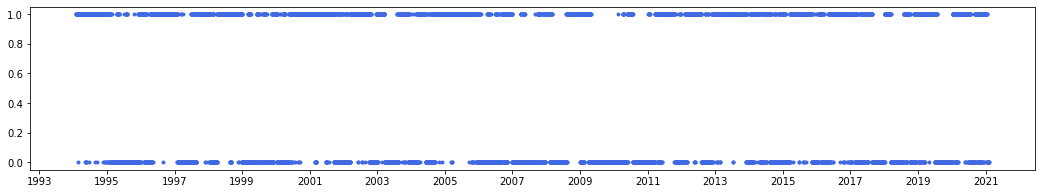

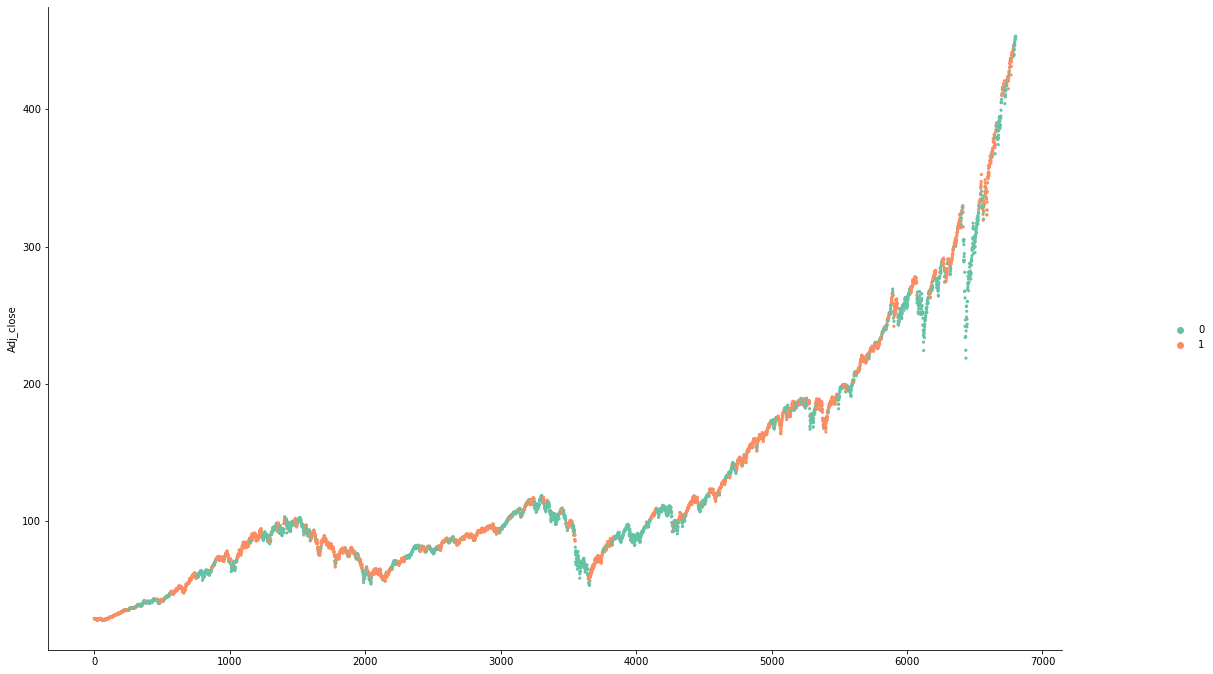

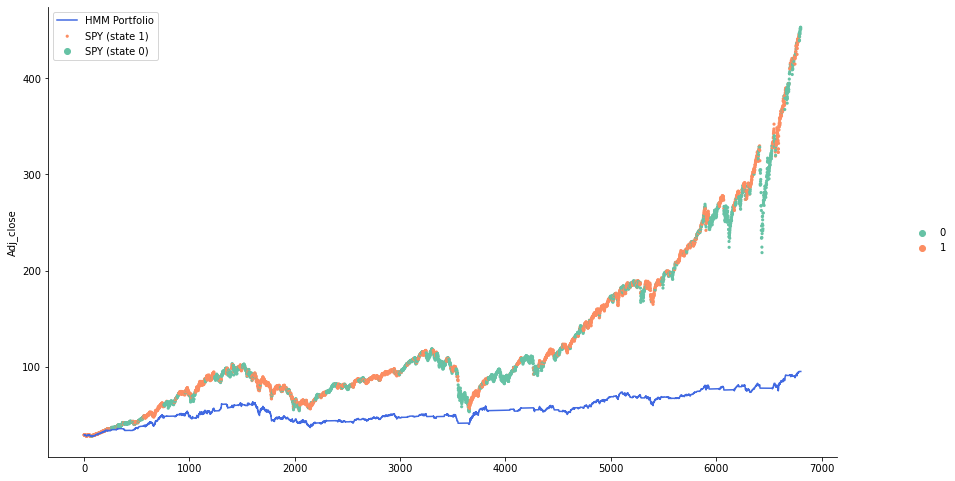

In [19]:
data, reg_df, current_state, portfolio_perf, portfolio_sharpe = compute_portfolio_save_performance(
    input_df=input_df,
    ticker=ticker,
    regression=regression,
    lassoCV=lassoCV,
    cv=cv,
    lookback=Neff,
    reg_lookback=reg_lookback)

In [20]:
# test_data = np.loadtxt("Portfolio_Performances/portfolio_260_NoReg.csv")

# test_df = pd.DataFrame(test_data,
#                        index=data.index[-len(test_data):])

In [21]:
# sharpe_ratio(test_df)

In [22]:
# # Import previous iterations using different Neff window lengths
# test_portfolio_750 = np.loadtxt("test_portfolio_750.csv")
# test_portfolio_500 = np.loadtxt("test_portfolio_500.csv")
# test_portfolio_250 = np.loadtxt("test_portfolio_250.csv")

# fig, ax = plt.subplots(figsize=(18,4))

# ax.plot(range(0,len(current_state)+500), data.Adj_close[2*250+1:], color='slategray');
# ax.plot(range(1000,len(current_state)+500), test_portfolio_750, color='royalblue');
# ax.plot(range(500,len(current_state)+500), test_portfolio_500, color='darkgreen');
# ax.plot(range(0,len(current_state)+500), test_portfolio_250, color='darkviolet');

# ax.legend(['SPY','HMM (750-day rolling window)', 'HMM (500-day rolling window)', 'HMM (250-day rolling window)']);

In [23]:
# spy_mean_return = data.Returns[2*Neff+1:].mean()
# spy_vol = data.Returns[2*Neff+1:].std()
# spy_sharpe = data.Returns[2*Neff+1:].mean() / data.Returns[2*Neff+1:].std()
# spy_sharpe*np.sqrt(252)

In [24]:
# # Empirical results

# spy_mean_return = data.Returns[2*Neff+1:].mean()
# spy_vol = data.Returns[2*Neff+1:].std()
# spy_sharpe = data.Returns[2*Neff+1:].mean() / data.Returns[2*Neff+1:].std()

# test_portfolio_750_returns = (test_portfolio_750[1:] - test_portfolio_750[:-1]) / test_portfolio_750[:-1]
# test_portfolio_750_sharpe = test_portfolio_750_returns.mean()/test_portfolio_750_returns.std()

# test_portfolio_500_returns = (test_portfolio_500[1:] - test_portfolio_500[:-1]) / test_portfolio_500[:-1]
# test_portfolio_500_sharpe = test_portfolio_500_returns.mean()/test_portfolio_500_returns.std()

# test_portfolio_250_returns = (test_portfolio_250[1:] - test_portfolio_250[:-1]) / test_portfolio_250[:-1]
# test_portfolio_250_sharpe = test_portfolio_250_returns.mean()/test_portfolio_250_returns.std()

# print(f'SPY average return: {spy_mean_return:.03f}')
# print(f'SPY volatility: {spy_vol:.03f}')
# print(f'SPY Sharpe Ratio: {spy_sharpe:.03f}')
# print('\n')
# print(f'HMM (750-day rolling window) average return: {data.Returns[2*Neff+1:].mean() :.05f}')
# print(f'HMM (750-day rolling window) volatility: {data.Returns[2*Neff+1:].std():.05f}')
# print(f'HMM (750-day rolling window) Sharpe Ratio: {test_portfolio_750_sharpe:.03f}')
# print('\n')
# print(f'HMM (500-day rolling window) average return: {test_portfolio_500_returns.mean():.05f}')
# print(f'HMM (500-day rolling window) volatility: {test_portfolio_500_returns.std():.05f}')
# print(f'HMM (500-day rolling window) Sharpe Ratio: {test_portfolio_500_sharpe:.03f}')
# print('\n')
# print(f'HMM (250-day rolling window) average return: {test_portfolio_250_returns.mean():.05f}')
# print(f'HMM (250-day rolling window) volatility: {test_portfolio_250_returns.std():.05f}')
# print(f'HMM (250-day rolling window) Sharpe Ratio: {test_portfolio_250_sharpe:.03f}')